In [1]:
import gc

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize
import numpy as np
import matplotlib
#matplotlib.use('agg')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp /content/drive/MyDrive/amex-default-prediction/data/raw/amex-default-prediction.zip .

In [ ]:
!unzip amex-default-prediction.zip train_data.csv

In [2]:
train_raw = pd.read_parquet('/home/sarath/uob/git/amex-default-prediction/data/processed/train.parquet')
labels = pd.read_csv('/home/sarath/uob/git/amex-default-prediction/data/processed/train_labels.csv')

In [3]:
print('Shape of train set : {:s}'.format(str(train_raw.shape)))
print('Shape of label set : {:s}'.format(str(labels.shape)))

Shape of train set : (5531451, 190)
Shape of label set : (458913, 2)


In [4]:
train_raw = pd.merge(train_raw, labels)

In [5]:
print("Shape of train set after merging labels : {:s}".format(str(train_raw.shape)))

Shape of train set after merging labels : (5531451, 191)


In [6]:
train_raw["S_2"] = pd.to_datetime(train_raw["S_2"])

<AxesSubplot:xlabel='S_2', ylabel='count'>

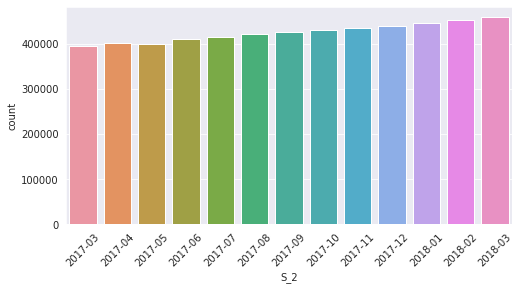

In [7]:
statement_date_group = train_raw.groupby(train_raw.S_2.dt.to_period('M')).size()
statement_date_group_df = pd.DataFrame(statement_date_group.to_frame())
statement_date_group_df.columns=['count']
plt.figure(figsize=(8, 4))
plt.xticks(rotation=45)
sns.barplot(x = statement_date_group_df.index, y = 'count' , data=statement_date_group_df)

In [8]:
print('Total number of categorical columns : {:s}.' .format(str(train_raw.select_dtypes(include=['category']).shape[1])))

Total number of categorical columns : 0.


In [9]:
categorical_features = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
train_raw[categorical_features] = train_raw[categorical_features].astype('category')
print('Total number of categorical columns : {:s}.' .format(str(train_raw.select_dtypes(include=['category']).shape[1])))

Total number of categorical columns : 11.


In [10]:
train_raw.dtypes.value_counts()

float32           93
int8              75
int16              9
category           4
category           2
object             1
datetime64[ns]     1
category           1
category           1
category           1
category           1
category           1
int64              1
dtype: int64

In [11]:
print('S_2 Range : {:s} to {:s}'.format(str(train_raw.S_2.min()), str(train_raw.S_2.max()) ))

S_2 Range : 2017-03-01 00:00:00 to 2018-03-31 00:00:00


In [12]:
null_values_stat = train_raw.isnull().sum().div(train_raw.shape[0]).mul(100) .sort_values(ascending=False)

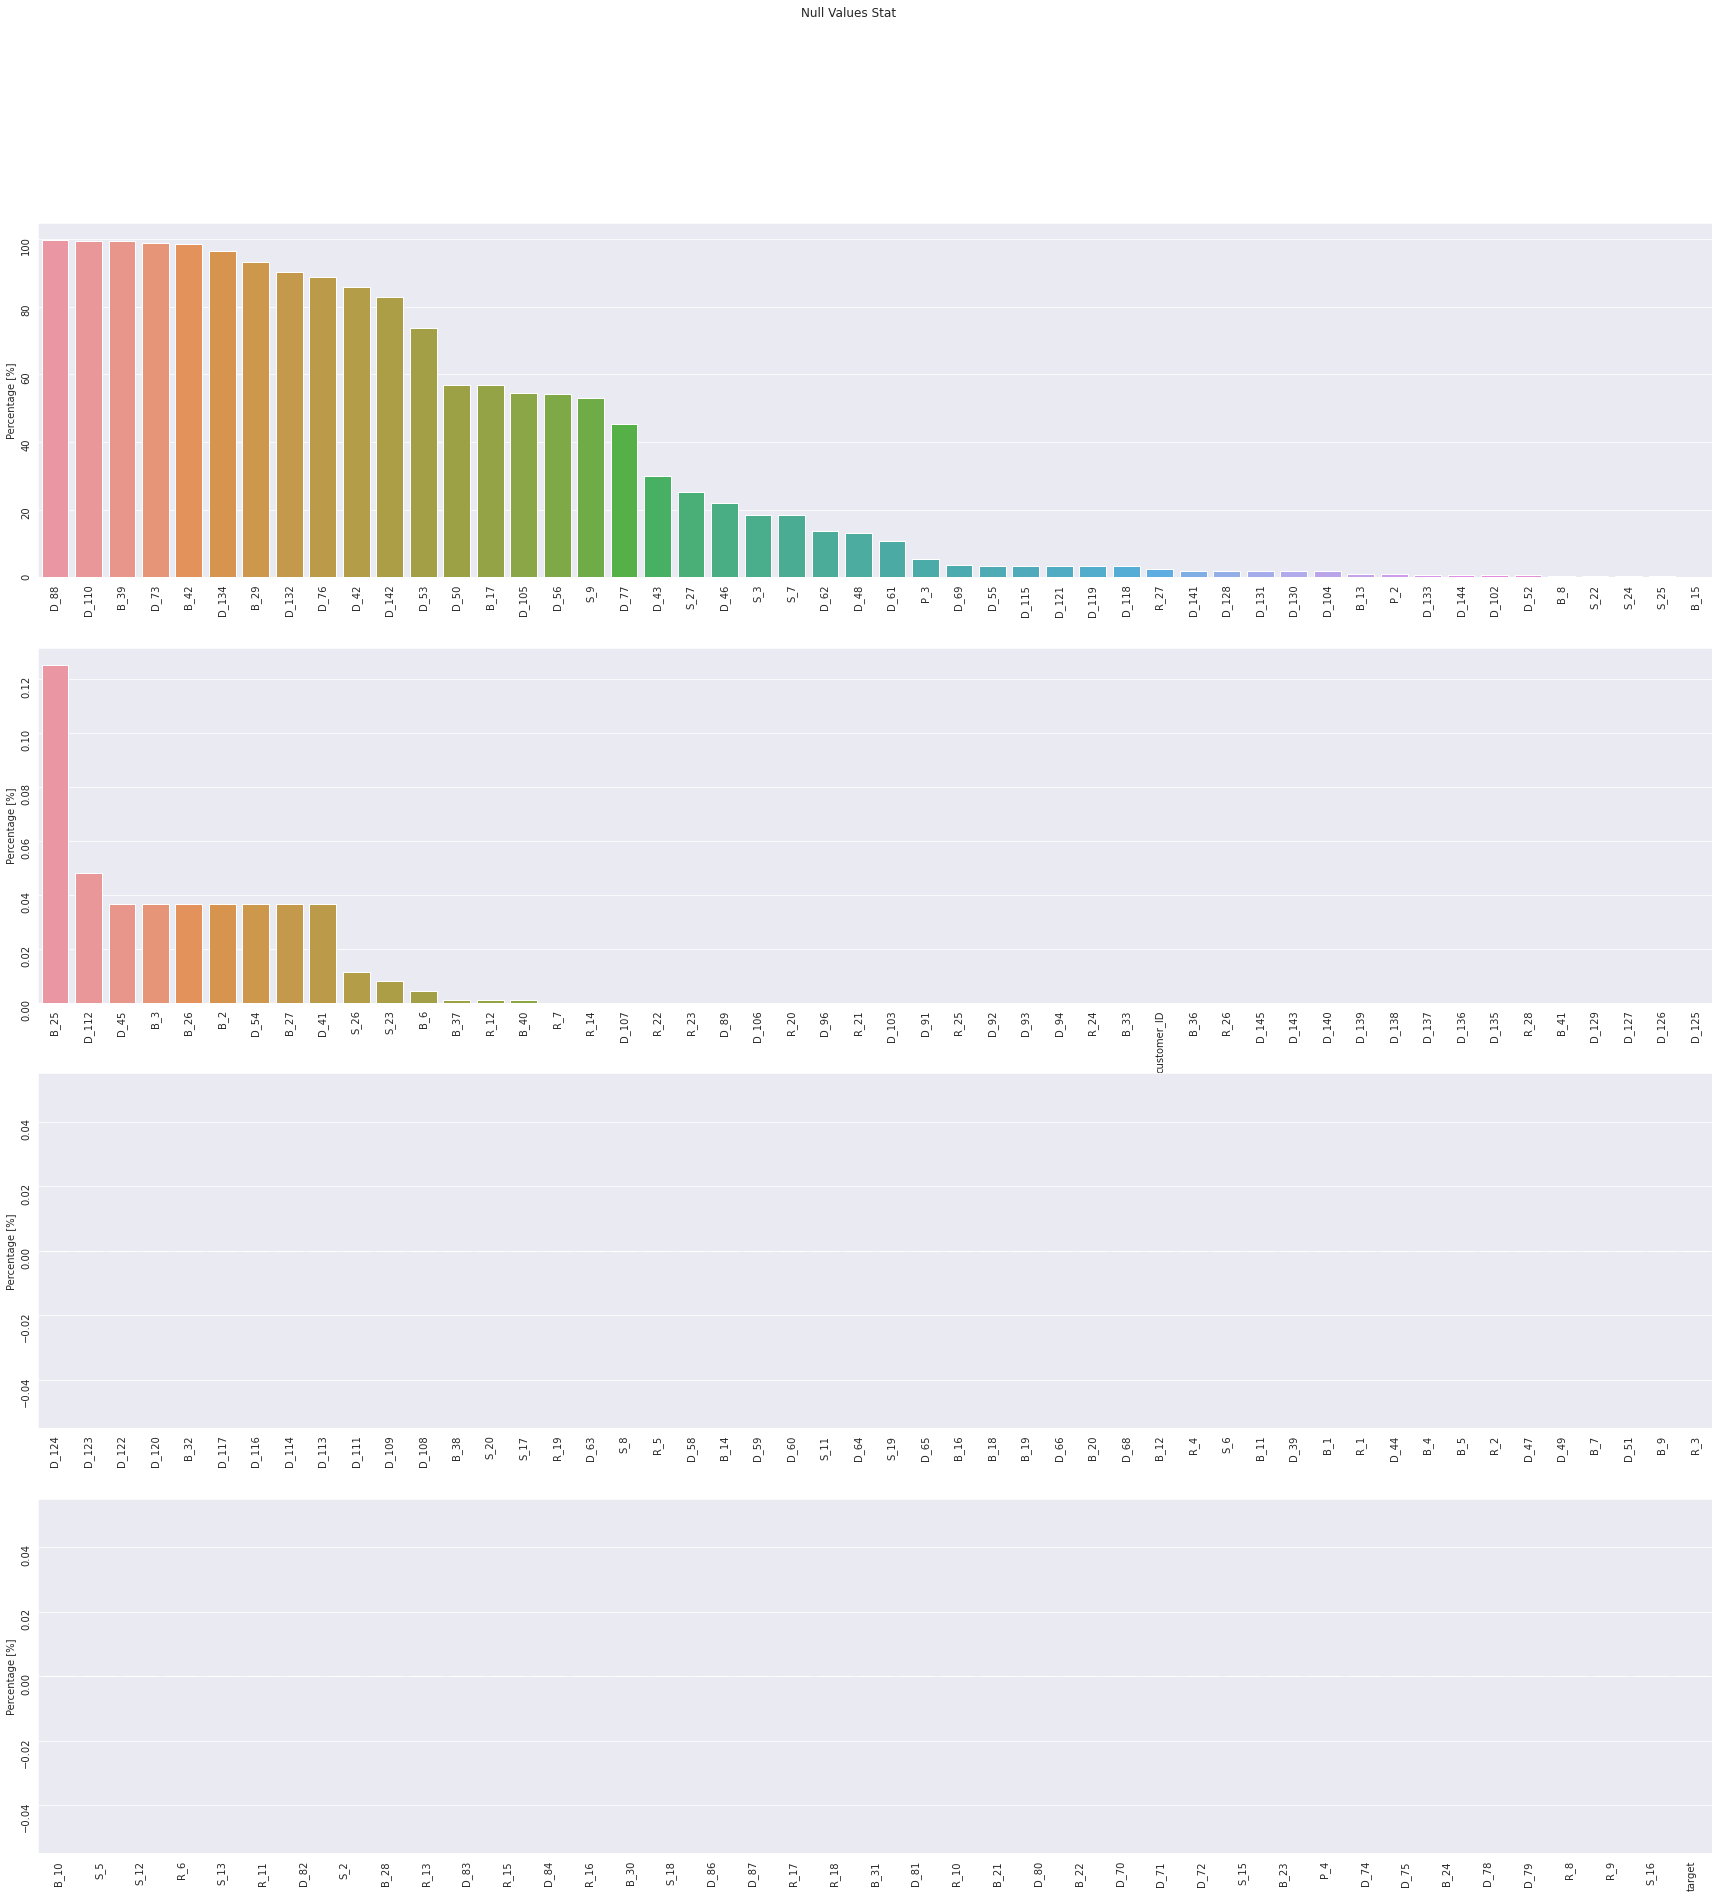

In [13]:
fig,ax = plt.subplots(4,1, figsize= (30, 30))
sns.barplot(x =null_values_stat.iloc[0:50].index, y = null_values_stat[0:50].values, ax=ax[0] )
sns.barplot(x =null_values_stat.iloc[50:100].index, y = null_values_stat[50:100].values, ax=ax[1] )
sns.barplot(x =null_values_stat.iloc[100:150].index, y = null_values_stat[100:150].values, ax=ax[2] )
sns.barplot(x =null_values_stat.iloc[150:191].index, y = null_values_stat[150:191].values, ax=ax[3] )

for i in range(0, 4):
    ax[i].set_ylabel('Percentage [%]')
    ax[i].tick_params(labelrotation=90)
plt.suptitle('Null Values Stat')
plt.show()

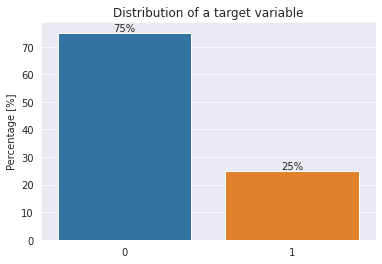

In [14]:
tvc = train_raw.target.value_counts() # type:pd.Series
tvc = tvc.transform(lambda x: x/x.sum()).mul(100)
ax = sns.barplot(x =tvc.index, y = tvc.values)
ax.bar_label(ax.containers[0], fmt='%.f%%')
plt.title("Distribution of a target variable")
plt.ylabel("Percentage [%]")
plt.show()

In [15]:
train_raw['customer_ID'].nunique()

458913

In [16]:
cust_data_dist_in_months = train_raw.groupby(['customer_ID', 'target']).size().reset_index().rename(columns={0:'number_of_months_data_available'})

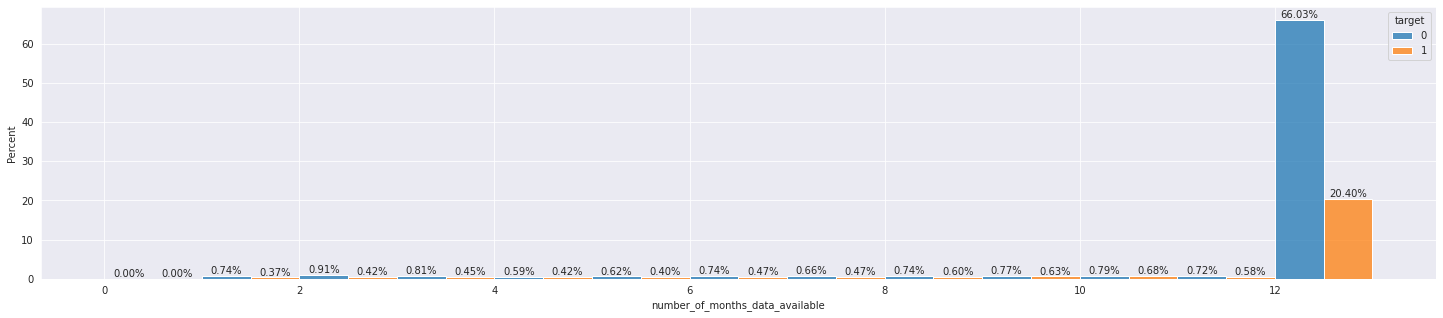

In [17]:
fig,ax = plt.subplots(1,1,figsize=(25, 5))
sns.histplot(data=cust_data_dist_in_months, x = 'number_of_months_data_available', hue='target', stat='percent', bins=range(0, 14), ax=ax, multiple='dodge')
ax.bar_label(ax.containers[0], fmt='%.2f%%')
ax.bar_label(ax.containers[1], fmt='%.2f%%')
plt.show()

In [18]:
def sample_cust(df, labels, ratio_of_cust):
    temp_df= train_raw[train_raw['customer_ID'].isin(labels['customer_ID'].sample(frac=ratio_of_cust))]
    print('Percentage of dataset sampled is {:2f}'.format(len(temp_df)/len(df)))
    return temp_df

In [19]:
sample_df = sample_cust(train_raw, labels, 0.1)
corr_with_target = sample_df.corrwith(sample_df['target'])

Percentage of dataset sampled is 0.099859


In [20]:
corr_with_target.sort_values(ascending=False).head(5)

target    1.000000
D_48      0.543344
B_9       0.489031
D_61      0.475838
D_55      0.451696
dtype: float64

In [21]:
sample_df['D_48'].describe()

count    480844.000000
mean          0.379862
std           0.325328
min          -0.009614
25%           0.080900
50%           0.282992
75%           0.664577
max           5.106712
Name: D_48, dtype: float64

In [22]:
sample_df['D_48'].isnull().sum()

71522

In [ ]:
numerical_features = sample_df.select_dtypes(include=np.number).columns
sns.set(rc={ 'figure.facecolor':'white'})

for col in numerical_features:
    fig,ax = plt.subplots(1,1, figsize=(10, 10))
    sns.displot(data=sample_df, x=col, hue='target')
    plt.savefig(col)
    plt.draw()
    plt.cla()
    plt.clf()
    plt.close('all')
    plt.close(fig)
    gc.collect()